# Machine Learning II

## 02 Image Features

In [9]:
from skimage import io, color, transform, feature, morphology, filters
import matplotlib.pyplot as plt
import os
import pandas as pd

#### Read example data

In [10]:
random_state = 203
HOME = cwd = os.getcwd()

classes = ['Apple', 'Banana', 'Carrot', 'Orange']
examplesDir = os.path.join(HOME, 'Fruitsv2', 'examples')
filename = [os.path.join(examplesDir, _) for _ in os.listdir(
            examplesDir) if (_.endswith('.jpg') or _.endswith('.JPEG'))]
df_examples = pd.DataFrame({'filepath': filename})
df_examples = df_examples.set_index([pd.Series(range(df_examples.shape[0]))])
for i, pth in enumerate(df_examples.filepath):
    for clss in classes:
        if clss in pth:
            df_examples.loc[i, 'label'] = clss

df_examples.sample(n=5)

,filepath,label
1,/home/nas/Research_Group/Personal/Jonas/DS_ML2...,Apple
8,/home/nas/Research_Group/Personal/Jonas/DS_ML2...,Carrot
12,/home/nas/Research_Group/Personal/Jonas/DS_ML2...,Orange
6,/home/nas/Research_Group/Personal/Jonas/DS_ML2...,Carrot
11,/home/nas/Research_Group/Personal/Jonas/DS_ML2...,Orange


### Color Histogram

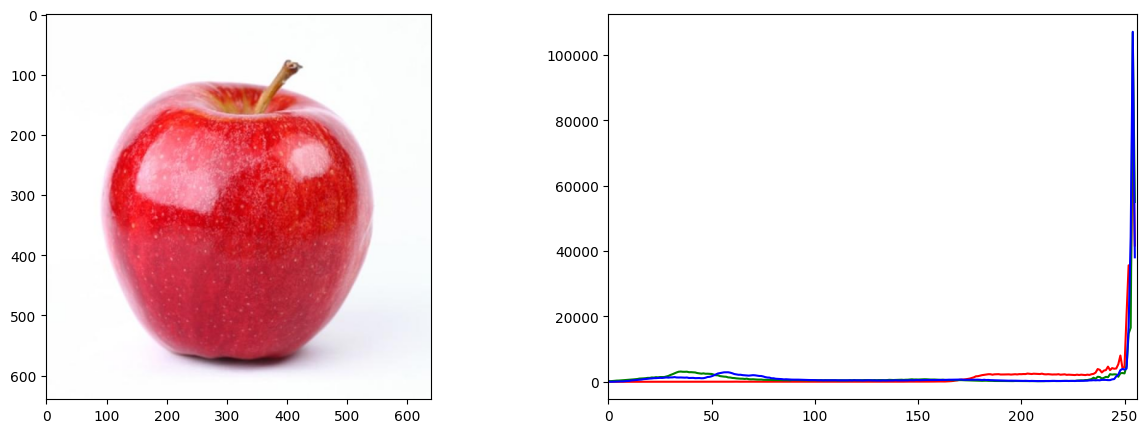

In [11]:
import numpy as np

path = df_examples.filepath.values[0]
# 讀取圖片
img_skimage = io.imread(path)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(img_skimage)

plt.subplot(122)
# 畫出 RGB 直方圖
colors = ('r', 'g', 'b')
for i, col in enumerate(colors):
    histr, _ = np.histogram(img_skimage[..., i].ravel(), bins=256, range=(0, 256))
    plt.plot(histr, color=col)
    plt.xlim([0, 256])
plt.show()


### Color Extraction

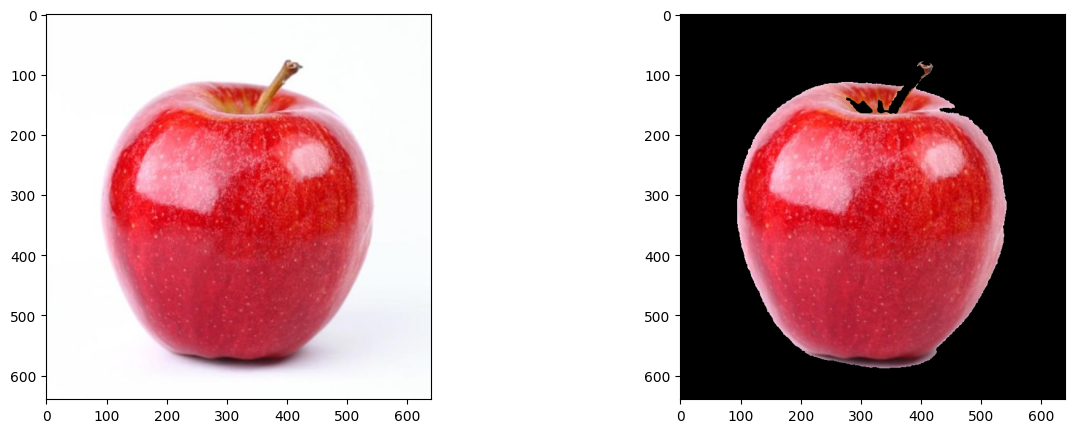

In [12]:
# Transform RGB img to HSV format, whose color can more easily be extracted.
# For HSV, hue range is [0,179], saturation range is [0,255], and value range is [0,255]
path = df_examples.filepath.values[0]


# 讀取圖片
img_skimage = io.imread(path)

# 將 RGB 圖片轉換成 HSV
hsv_skimage = color.rgb2hsv(img_skimage)

# 定義 HSV 中的紅色遮罩
red_min = ((hsv_skimage[..., 0] >= 0) & (hsv_skimage[..., 0] <= 10/180) &
           (hsv_skimage[..., 1] >= 43/255) & (hsv_skimage[..., 2] >= 46/255))
red_max = ((hsv_skimage[..., 0] >= 156/180) & (hsv_skimage[..., 0] <= 180/180) &
           (hsv_skimage[..., 1] >= 43/255) & (hsv_skimage[..., 2] >= 46/255))
red_mask = red_min | red_max

# 使用遮罩於原始圖像
img_color_skimage = img_skimage * red_mask[:, :, np.newaxis]

plt.figure(figsize=(15, 5)) 
plt.subplot(121)
plt.imshow(img_skimage)
plt.subplot(122)
plt.imshow(img_color_skimage)
plt.show()

### Exercise (10 mins)
#### Experiment with various HSV masks to identify the optimal range of hue values that effectively define the best threshold for your image.

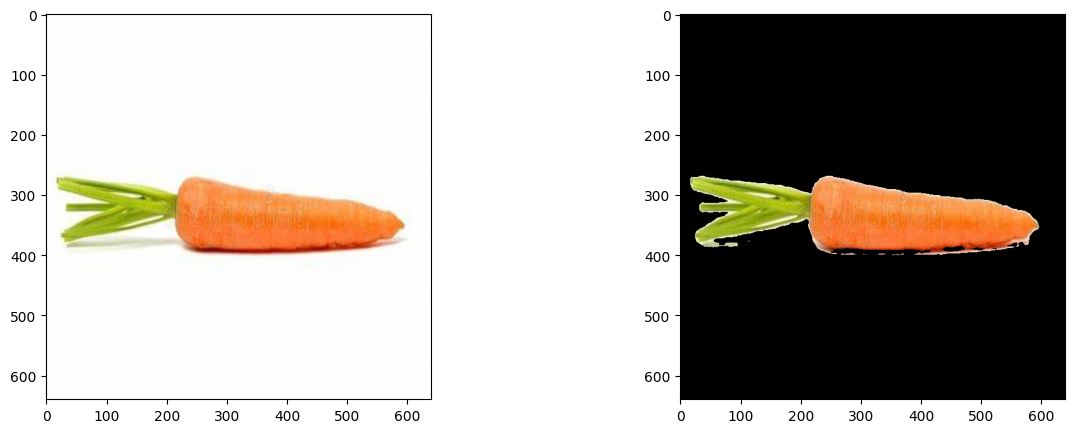

In [13]:
# 讀取圖片
random_image = df_examples.sample(n=1)
path = random_image.filepath.values[0]
img_skimage = io.imread(path)

# 將 RGB 圖片轉換成 HSV
hsv_skimage = color.rgb2hsv(img_skimage)
img_label = random_image.label.values[0]
# 根據給定的標籤定義顏色遮罩
if img_label == "Apple":
    red_min = ((hsv_skimage[..., 0] >= 0) & (hsv_skimage[..., 0] <= 34/180) &
               (hsv_skimage[..., 1] >= 43/255) & (hsv_skimage[..., 2] >= 46/255))
    red_max = ((hsv_skimage[..., 0] >= 156/180) & (hsv_skimage[..., 0] <= 180/180) &
               (hsv_skimage[..., 1] >= 43/255) & (hsv_skimage[..., 2] >= 46/255))
    color_mask = red_min | red_max
elif img_label == "Banana":
    color_mask = ((hsv_skimage[..., 0] >= 11/180) & (hsv_skimage[..., 0] <= 34/180) &
                  (hsv_skimage[..., 1] >= 43/255) & (hsv_skimage[..., 2] >= 46/255))
elif img_label == "Carrot":
    color_mask = ((hsv_skimage[..., 0] >= 5/180) & (hsv_skimage[..., 0] <= 77/180) &
                  (hsv_skimage[..., 1] >= 43/255) & (hsv_skimage[..., 2] >= 46/255))
elif img_label == "Orange":
    color_mask = ((hsv_skimage[..., 0] >= 5/180) & (hsv_skimage[..., 0] <= 25/180) &
                  (hsv_skimage[..., 1] >= 43/255) & (hsv_skimage[..., 2] >= 46/255))

# 使用遮罩於原始圖像
img_color_skimage = img_skimage * color_mask[:, :, np.newaxis]

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(img_skimage)
plt.subplot(122)
plt.imshow(img_color_skimage)
plt.show()


### Texture Extraction

In [14]:
from skimage.feature import graycomatrix, graycoprops
import numpy as np
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

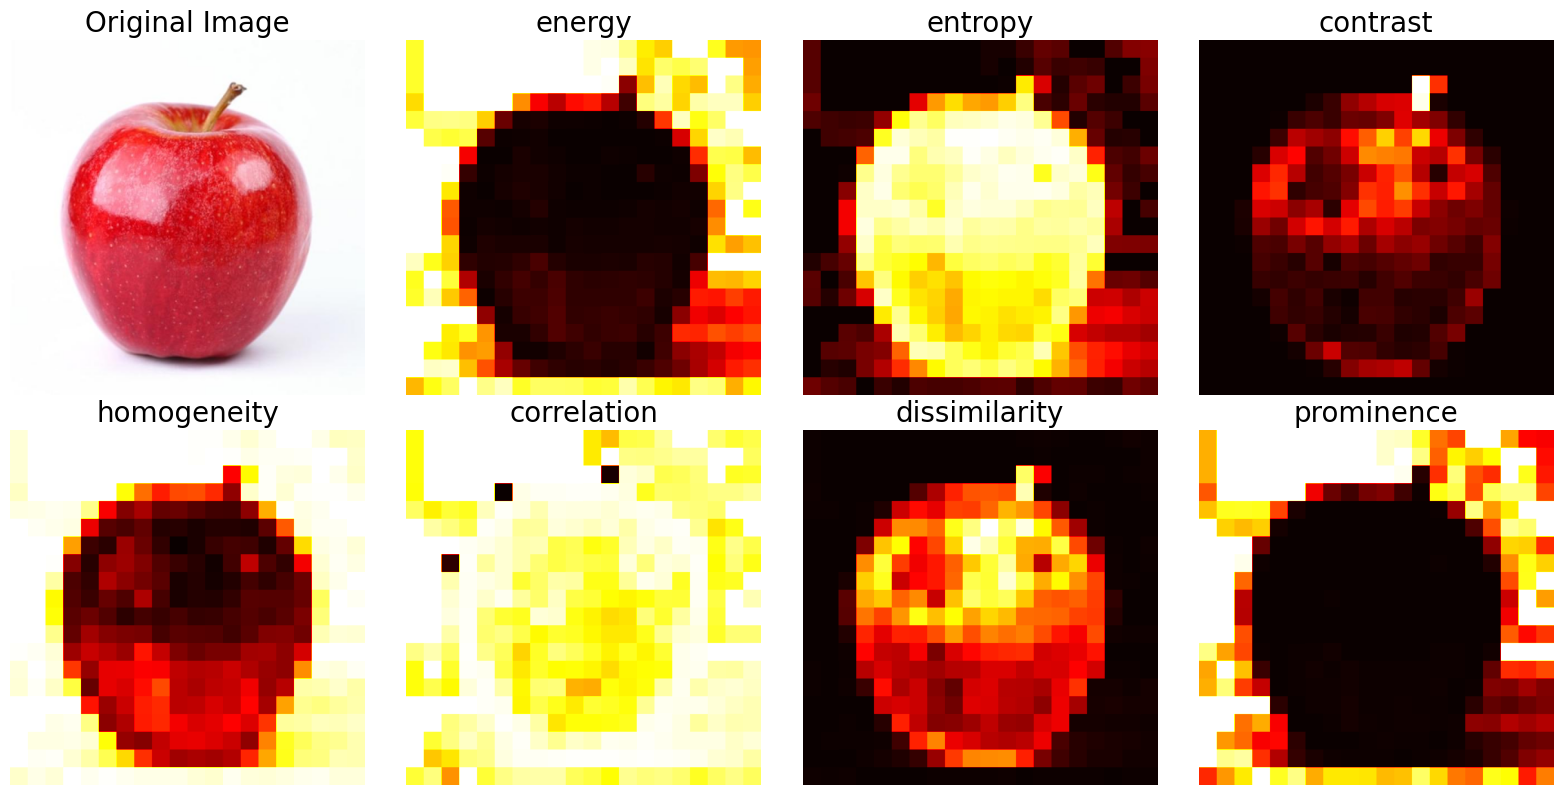

In [15]:
def generate_heatmaps(image_path, patch_size):
    # Load the image and convert it to grayscale
    image = io.imread(image_path)
    gray_image = rgb2gray(image)
    
    gray_image = (gray_image * 255).astype(np.uint8)
    
    # Assuming the patches are non-overlapping, calculate the number of patches
    patches = [gray_image[i:i+patch_size, j:j+patch_size]
               for i in range(0, gray_image.shape[0], patch_size)
               for j in range(0, gray_image.shape[1], patch_size)]
    
    # List to store the heatmaps
    heatmaps = []
    
    # GLCM properties to compute
    properties = ['energy', 'entropy', 'contrast', 'homogeneity', 'correlation', 'dissimilarity', 'prominence']
    
    for prop in properties:
        # Initialize an empty image to store the GLCM property values
        prop_image = np.zeros_like(gray_image, dtype=np.float64)
        
        for i, patch in enumerate(patches):
            # Calculate the row, col position of the patch in the original image
            row, col = divmod(i, gray_image.shape[1] // patch_size)
            # Compute GLCM
            glcm = graycomatrix(patch, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
            # Compute GLCM property
            if prop == 'entropy':
                prop_value = -np.sum(glcm*np.log2(glcm + np.finfo(float).eps))
            elif prop == 'prominence':
                prop_value = graycoprops(glcm, 'ASM').mean()
            else:
                prop_value = graycoprops(glcm, prop).mean()
            
            # Fill the corresponding area of the prop_image
            prop_image[row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = prop_value
        
        # Normalize the prop_image values between 0 and 1
        min_val = np.min(prop_image)
        max_val = np.max(prop_image)
        prop_image = (prop_image - min_val) / (max_val - min_val)
        
        heatmaps.append(prop_image)
    
    # Plotting the heatmaps
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    
    # Set the figure background to transparent
    fig.patch.set_facecolor('none')
    
    # Plot the original grayscale image
    axs[0, 0].imshow(image)
    axs[0, 0].set_title('Original Image', fontsize=20)
    axs[0, 0].axis('off')
    
    # Plot the heatmaps
    for i, ax in enumerate(axs.flat[1:]):  # Start from the second subplot
        ax.imshow(heatmaps[i], cmap='hot')
        ax.set_title(properties[i], fontsize=20)
        ax.axis('off')
    
    # Hide the empty subplot(s)
    for i in range(len(properties) + 1, 8):  # Adjust as needed
        axs.flat[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{image_path}heatmaps.jpg', transparent=True)
    plt.show()

patch_size = 32
path = df_examples.filepath.values[0]
generate_heatmaps(path, patch_size=patch_size)

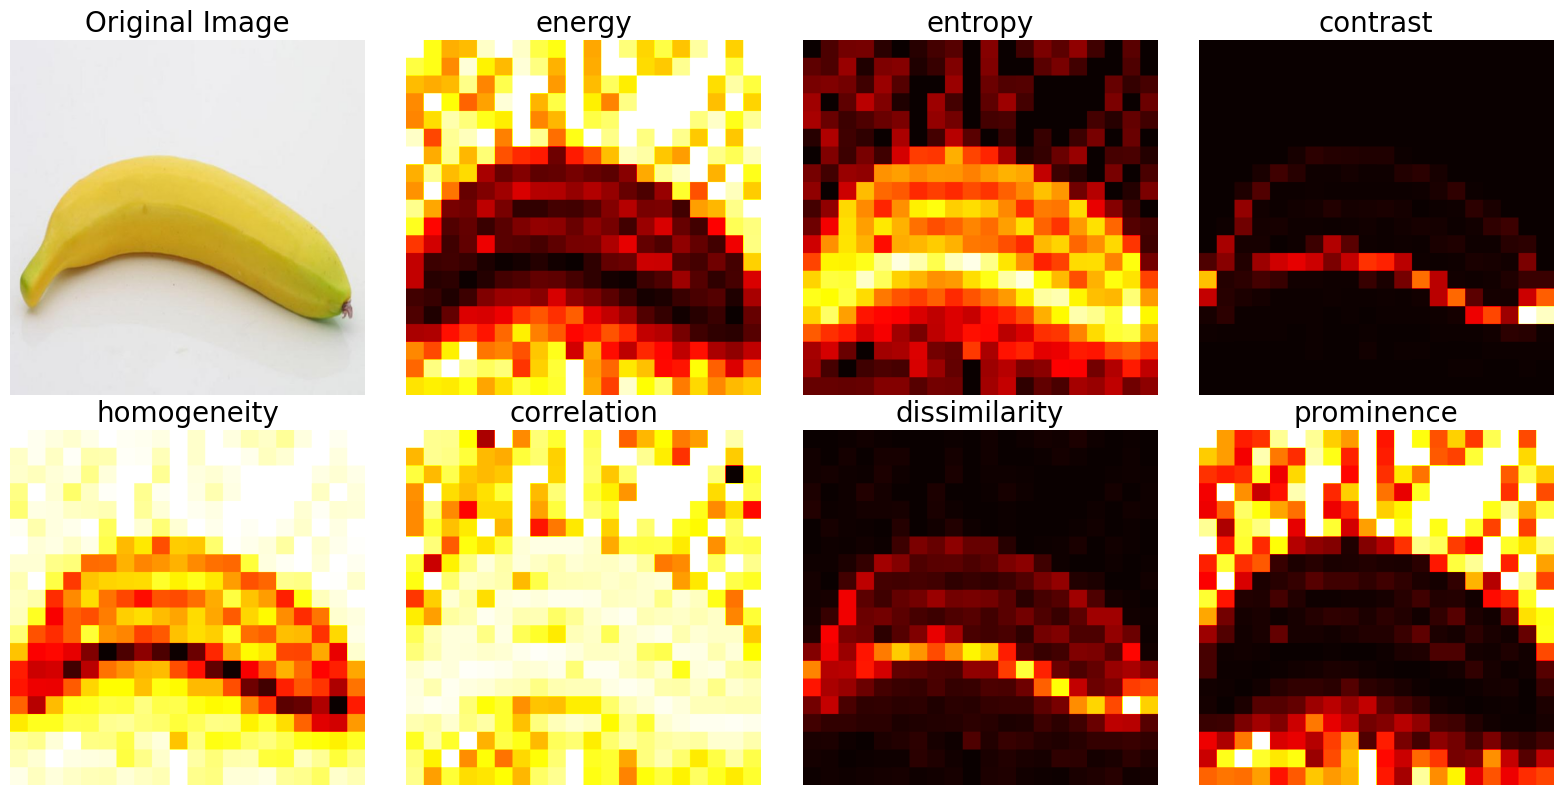

In [16]:
path = df_examples.filepath.values[2]
generate_heatmaps(path, patch_size=patch_size)

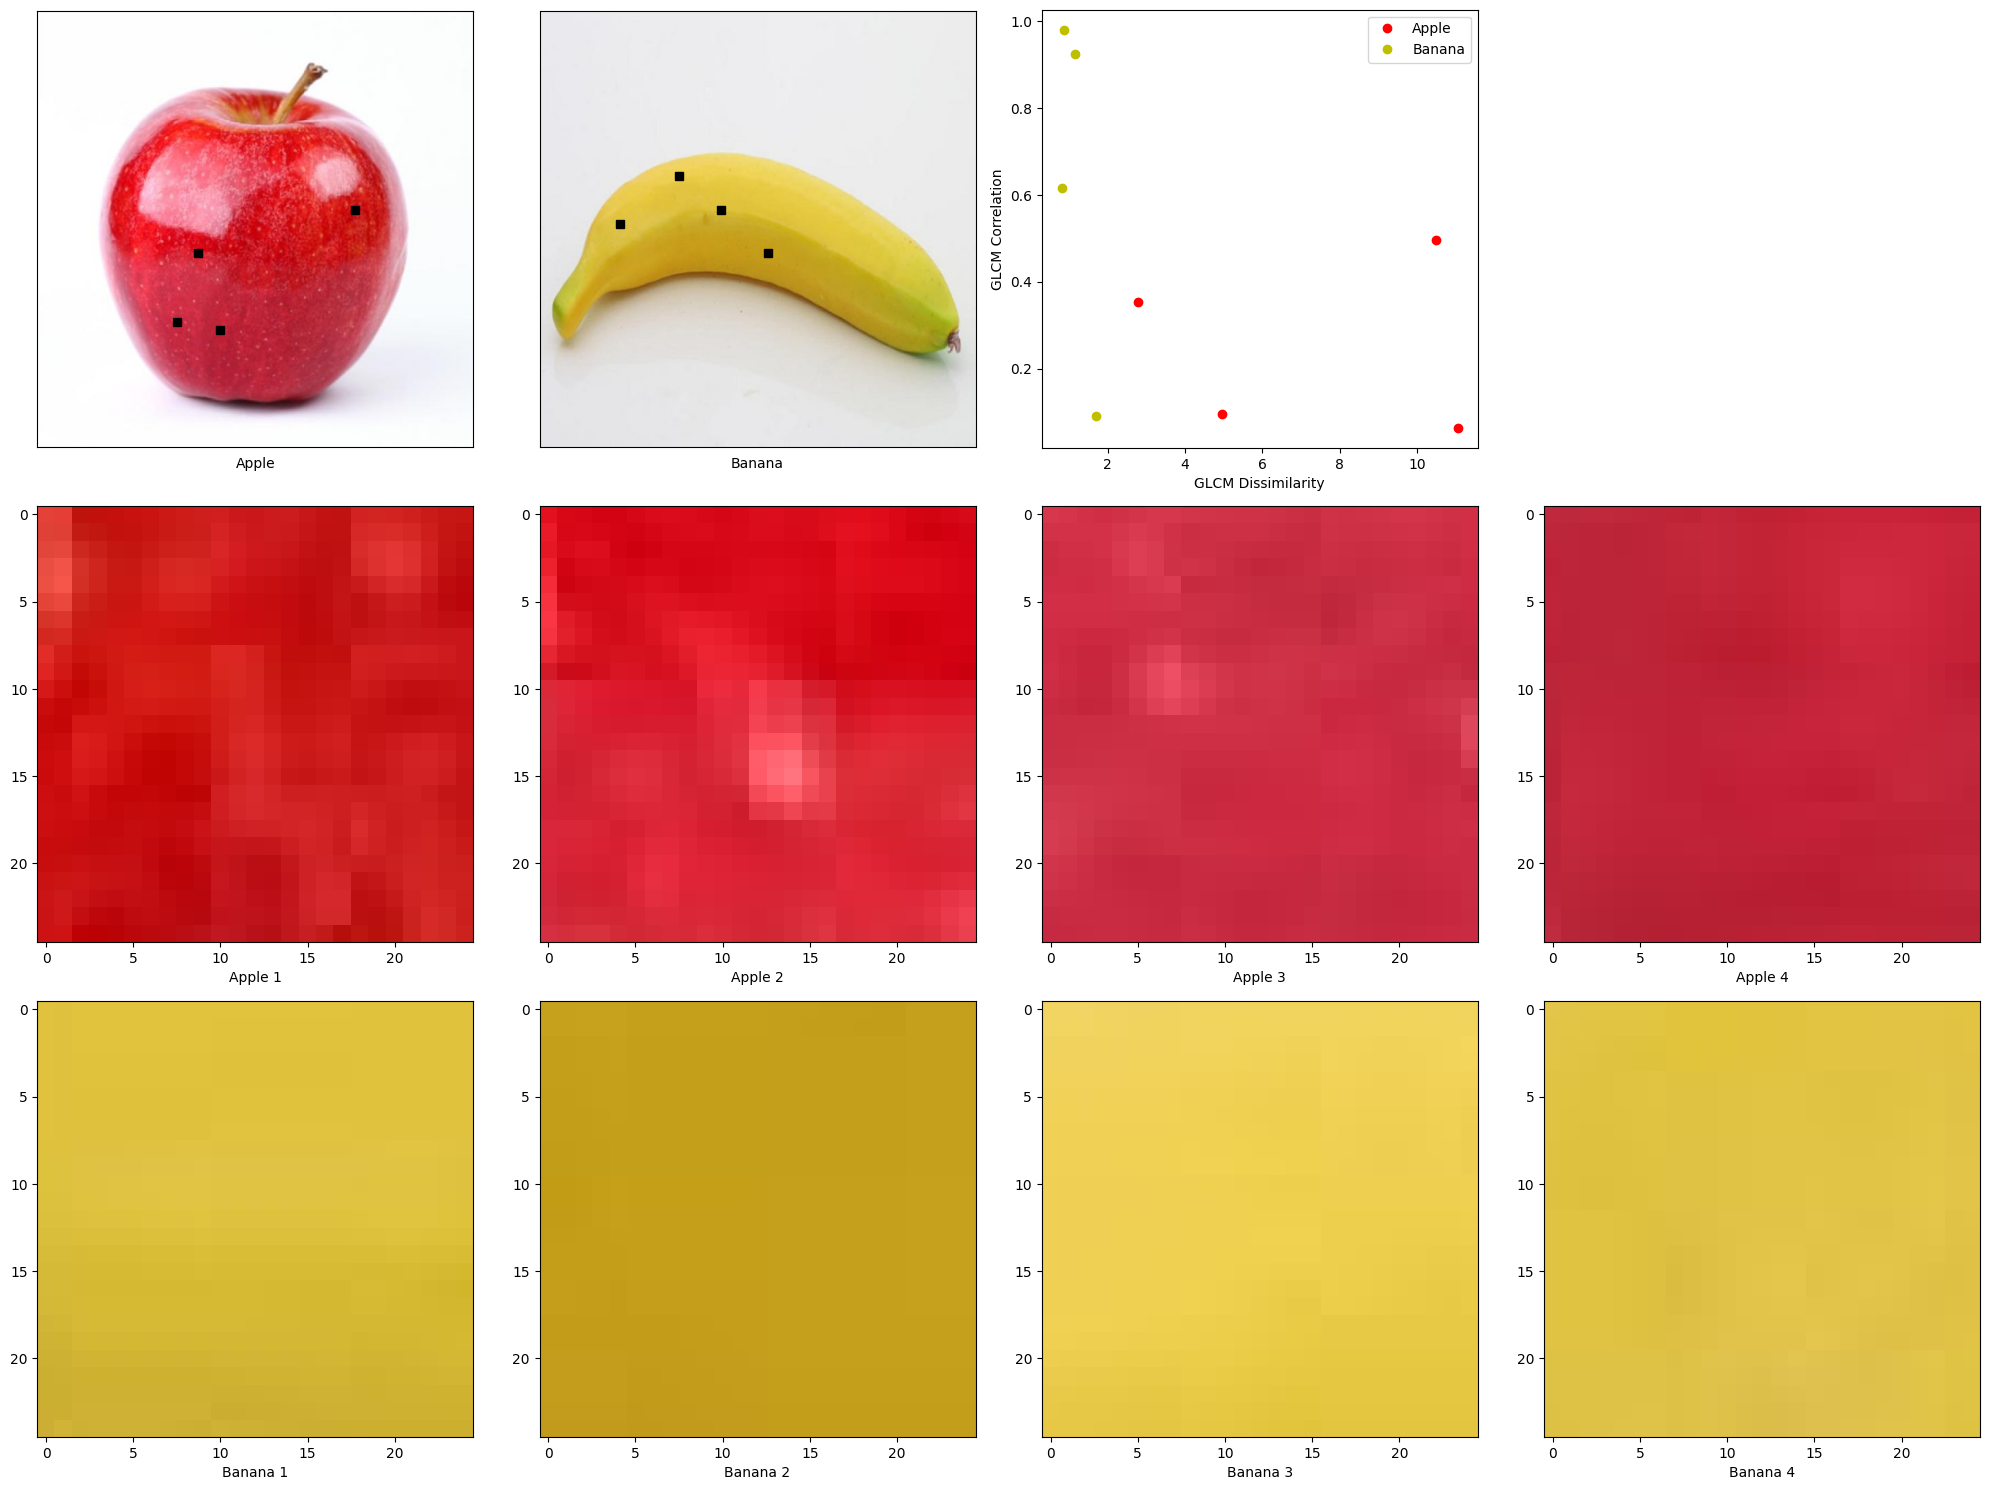

In [17]:
# 定義片段大小
PATCH_SIZE = 25

# 讀取蘋果圖片並轉換成灰度格式
path = df_examples[df_examples['label']=='Apple'].filepath.values[0]
apple_skimage = io.imread(path)
apple_gray_skimage = color.rgb2gray(apple_skimage) * 255
apple_gray_skimage = apple_gray_skimage.astype(np.uint8)

# 從蘋果圖片中提取片段
apple_locations = [(280, 454), (342, 223), (444, 192), (455, 255)]
apple_patches_skimage = []
for loc in apple_locations:
    apple_patches_skimage.append(apple_gray_skimage[loc[0]:loc[0] + PATCH_SIZE,
                                                    loc[1]:loc[1] + PATCH_SIZE])

# 讀取香蕉圖片並轉換成灰度格式
path = df_examples[df_examples['label']=='Banana'].filepath.values[0]
banana_skimage = io.imread(path)
banana_gray_skimage = color.rgb2gray(banana_skimage) * 255
banana_gray_skimage = banana_gray_skimage.astype(np.uint8)

# 從香蕉圖片中提取片段
banana_locations = [(280, 254), (342, 323), (230, 192), (300, 105)]
banana_patches_skimage = []
for loc in banana_locations:
    banana_patches_skimage.append(banana_gray_skimage[loc[0]:loc[0] + PATCH_SIZE,
                                                      loc[1]:loc[1] + PATCH_SIZE])

# 計算每個片段的 GLCM 屬性
xs_skimage = []
ys_skimage = []
for patch in (apple_patches_skimage + banana_patches_skimage):
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs_skimage.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    ys_skimage.append(graycoprops(glcm, 'correlation')[0, 0]) 

# 可視化
# Visualization

# Creating the figure
fig = plt.figure(figsize=(20, 15))

# Displaying apple with locations of patches
ax = fig.add_subplot(3, 4, 1)
ax.imshow(apple_skimage)
for (y, x) in apple_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'ks')
ax.set_xlabel('Apple')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# Displaying banana with locations of patches
ax = fig.add_subplot(3, 4, 2)
ax.imshow(banana_skimage)
for (y, x) in banana_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'ks')
ax.set_xlabel('Banana')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# For each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 4, 3)
ax.plot(xs_skimage[:len(apple_patches_skimage)], ys_skimage[:len(apple_patches_skimage)], 'ro',
        label='Apple')
ax.plot(xs_skimage[len(banana_patches_skimage):], ys_skimage[len(banana_patches_skimage):], 'yo',
        label='Banana')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# Display the image patches
for i, loc in enumerate(apple_locations):
    ax = fig.add_subplot(3, len(apple_patches_skimage), len(apple_patches_skimage)*1 + i + 1)
    patch = apple_skimage[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE]
    ax.imshow(patch)
    ax.set_xlabel(f"Apple {i + 1}")

for i, loc in enumerate(banana_locations):
    ax = fig.add_subplot(3, len(banana_patches_skimage), len(banana_patches_skimage)*2 + i + 1)
    patch = banana_skimage[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE]
    ax.imshow(patch)
    ax.set_xlabel(f"Banana {i + 1}")



plt.tight_layout()
plt.show()


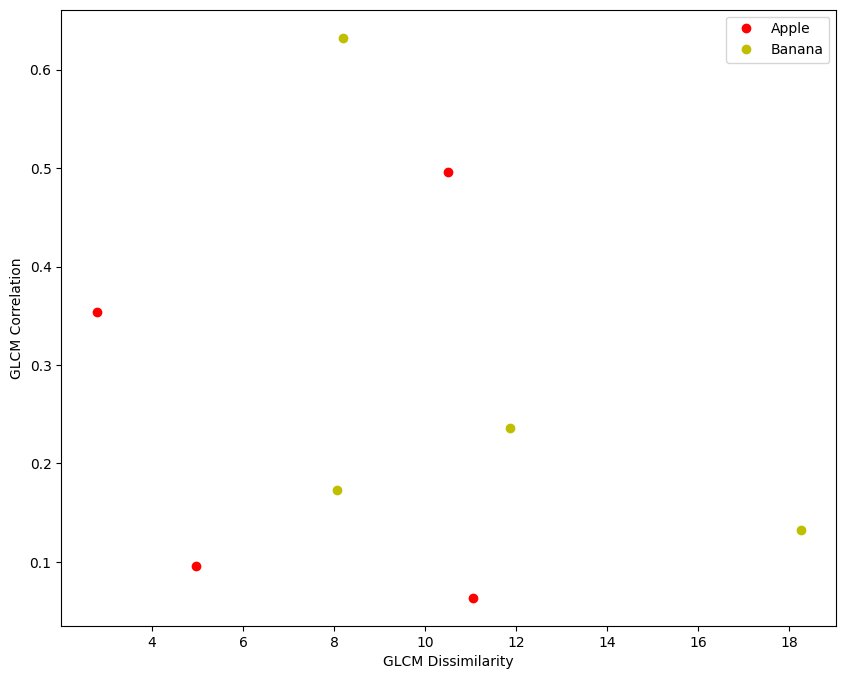

In [37]:
# Plotting GLCM Dissimilarity vs GLCM Correlation
fig = plt.figure(figsize=(10, 8))

# For each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(111)
ax.plot(xs_skimage[:len(apple_patches_skimage)], ys_skimage[:len(apple_patches_skimage)], 'ro',
        label='Apple')
ax.plot(xs_skimage[len(banana_patches_skimage):], ys_skimage[len(banana_patches_skimage):], 'yo',
        label='Banana')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

plt.show()

## 03 How to Train an Image Classifier


### Dataset Preparation

In [12]:
import os
import pandas as pd

random_state = 203
dataDir = 'Fruitsv2'
phases = ['train', 'valid', 'test']
classes = ['Apple', 'Banana', 'Carrot', 'Orange']
class_labels = {'Apple': 0, 'Banana': 1, 'Carrot': 2, 'Orange': 3}
df = pd.DataFrame([], columns=['filepath', 'class', 'label', 'phase'])

for phs in phases:
    for c in classes:
        imgDir = os.path.join(dataDir, phs, c)
        filename = [os.path.join(imgDir, _) for _ in os.listdir(
            imgDir) if (_.endswith('.jpg') or _.endswith('.JPEG'))]
        tmp = pd.DataFrame({'filepath': filename})
        tmp['class'] = c
        tmp['label'] = class_labels[c]
        tmp['phase'] = phs
        df = pd.concat([df, tmp])

df.label = df.label.astype('int')
df = df.set_index([pd.Series(range(df.shape[0]))])
df.sample(n=5)


,filepath,class,label,phase
1060,Fruitsv2\train\Orange\6968864_3_jpg.rf.2b908a8...,Orange,3,train
153,Fruitsv2\train\Apple\apple-302287_640_jpg.rf.f...,Apple,0,train
1459,Fruitsv2\test\Apple\9018_original_jpg.rf.f0c00...,Apple,0,test
30,Fruitsv2\train\Apple\11381-an-apple-isolated-o...,Apple,0,train
137,Fruitsv2\train\Apple\aee62e9e0fb2b763_jpg.rf.a...,Apple,0,train


In [13]:
df_shape = pd.DataFrame([], columns=classes, index=phases)

for phs in phases:
    for c in classes:
        mask2 = df['phase'] == phs
        mask1 = df['class'] == c
        df_shape.loc[phs][c] = df[mask1 & mask2].shape[0]

df_shape


,Apple,Banana,Carrot,Orange
train,356,385,230,318
valid,43,46,30,42
test,39,51,33,37


#### Extract GLCM features from dataset

In [14]:
from skimage.feature.texture import graycomatrix, graycoprops
from tqdm.notebook import tqdm
import numpy as np
from skimage import io, color

def add_glcm_skimage(df, features):
    df_glcm = df.copy(deep=True)
    degrees = [0]

    for i in tqdm(df_glcm.index):
        for feat in features:
            path = df_glcm.loc[i, 'filepath']
            
            # Using skimage to read the image and convert it to grayscale
            img_skimage = io.imread(path)
            gray_skimage = color.rgb2gray(img_skimage) * 255
            gray_skimage = gray_skimage.astype(np.uint8)
            
            glcm = graycomatrix(gray_skimage,
                                distances=[5],
                                angles=np.radians(degrees),
                                levels=256,
                                symmetric=True,
                                normed=True)
            val = graycoprops(glcm, feat)
            for j, degree in enumerate(degrees):
                df_glcm.loc[i, feat] = val[0][j]
    return df_glcm

In [15]:
n = 5
glcm_features = ['dissimilarity', 'homogeneity',
            'contrast', 'energy', 'ASM', 'correlation']
df = add_glcm_skimage(df, glcm_features)
df.head(n)

  0%|          | 0/1610 [00:00<?, ?it/s]

,filepath,class,label,phase,dissimilarity,homogeneity,contrast,energy,ASM,correlation
0,Fruitsv2\train\Apple\00_m_jpg.rf.cac94222ac6af...,Apple,0,train,6.501885,0.295918,217.294198,0.038033,0.001447,0.955161
1,Fruitsv2\train\Apple\006b4e6f706e3119_jpg.rf.3...,Apple,0,train,2.799700,0.673561,158.700305,0.270645,0.073249,0.965453
2,Fruitsv2\train\Apple\0148_jpg.rf.7f31c6a9270b4...,Apple,0,train,9.293302,0.154088,240.320487,0.018463,0.000341,0.855396
3,Fruitsv2\train\Apple\015415912756_jpg.rf.fdb37...,Apple,0,train,10.501873,0.129921,288.388221,0.012305,0.000151,0.939608
4,Fruitsv2\train\Apple\018257a792aa90e6_jpg.rf.a...,Apple,0,train,12.090015,0.238860,701.915659,0.029036,0.000843,0.873054


#### Extract color features from dataset <br>
Here we extract the RGB color mean and standard deviation.

In [16]:
color_features = ['b_mean', 'b_std', 'g_mean', 'g_std', 'r_mean', 'r_std']
def add_color_skimage(df, features):
    df_color = df.copy(deep=True)
    degrees = [0]

    for i in tqdm(df_color.index):
        path = df_color.loc[i, 'filepath']
        
        # Using skimage to read the image
        img_skimage = io.imread(path)
        
        # skimage reads images in RGB order, so we don't need to swap channels
        for j in range(3):
            df_color.loc[i, color_features[j*2]] = np.mean(img_skimage[:, :,j])
            df_color.loc[i, color_features[j*2+1]] = np.std(img_skimage[:, :,j])

    return df_color

In [17]:
df = add_color_skimage(df, color_features)
df.head(n)

  0%|          | 0/1610 [00:00<?, ?it/s]

,filepath,class,label,phase,dissimilarity,homogeneity,contrast,energy,ASM,correlation,b_mean,b_std,g_mean,g_std,r_mean,r_std
0,Fruitsv2\train\Apple\00_m_jpg.rf.cac94222ac6af...,Apple,0,train,6.501885,0.295918,217.294198,0.038033,0.001447,0.955161,66.623433,68.451170,46.297046,48.028944,42.018462,45.103031
1,Fruitsv2\train\Apple\006b4e6f706e3119_jpg.rf.3...,Apple,0,train,2.799700,0.673561,158.700305,0.270645,0.073249,0.965453,27.883315,54.453529,24.830815,49.259327,12.940220,20.628222
2,Fruitsv2\train\Apple\0148_jpg.rf.7f31c6a9270b4...,Apple,0,train,9.293302,0.154088,240.320487,0.018463,0.000341,0.855396,100.284414,46.931688,79.201018,31.996255,57.234070,29.402147
3,Fruitsv2\train\Apple\015415912756_jpg.rf.fdb37...,Apple,0,train,10.501873,0.129921,288.388221,0.012305,0.000151,0.939608,162.143779,59.271150,146.063267,52.755224,127.186855,54.872510
4,Fruitsv2\train\Apple\018257a792aa90e6_jpg.rf.a...,Apple,0,train,12.090015,0.238860,701.915659,0.029036,0.000843,0.873054,170.415691,39.788069,137.480137,55.534463,83.200801,76.466804


### Model training and evaluation

#### Split Dataset

In [19]:
from sklearn.preprocessing import StandardScaler


X_train = df[df['phase'] == 'train'][glcm_features]
Y_train = df.loc[X_train.index, 'label']

X_valid = df[df['phase'] == 'valid'][glcm_features]
Y_valid = df.loc[X_valid.index, 'label']

X_test = df[df['phase'] == 'test'][glcm_features]
Y_test = df.loc[X_test.index, 'label']

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)


In [20]:
df[df['phase'] == 'train'][glcm_features]

,dissimilarity,homogeneity,contrast,energy,ASM,correlation
0,6.501885,0.295918,217.294198,0.038033,0.001447,0.955161
1,2.799700,0.673561,158.700305,0.270645,0.073249,0.965453
2,9.293302,0.154088,240.320487,0.018463,0.000341,0.855396
3,10.501873,0.129921,288.388221,0.012305,0.000151,0.939608
4,12.090015,0.238860,701.915659,0.029036,0.000843,0.873054
...,...,...,...,...,...,...
1284,3.944402,0.603758,99.264117,0.341525,0.116640,0.986409
1285,3.955497,0.500557,82.251585,0.073620,0.005420,0.985849
1286,7.249653,0.301749,219.393629,0.028262,0.000799,0.974196
1287,6.395482,0.467513,246.507052,0.158570,0.025144,0.977747


#### Decision Tree

In [21]:
from sklearn import tree

# Train a decision tree model
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
decision_tree = tree.DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=random_state)


In [22]:
from sklearn.metrics import roc_auc_score as ras

decision_tree.fit(X_train, Y_train.values)

# Evaluate the decision tree accuracy on train and validation sets
train_preds = decision_tree.predict_proba(X_train)
print('Training Accuracy : ', ras(Y_train.values, train_preds, multi_class='ovr'))
valid_preds = decision_tree.predict_proba(X_valid)
print('Validation Accuracy : ', ras(
    Y_valid.values, valid_preds, multi_class='ovr'))

Training Accuracy :  0.9999887340039079
Validation Accuracy :  0.7094272650892368


In [23]:
from sklearn.tree import export_text

# Let's see what the tree looks like
r = export_text(decision_tree, feature_names=glcm_features)
print(r)


|--- correlation <= 0.24
|   |--- homogeneity <= -0.58
|   |   |--- ASM <= -0.59
|   |   |   |--- dissimilarity <= -0.09
|   |   |   |   |--- correlation <= -0.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- correlation >  -0.20
|   |   |   |   |   |--- homogeneity <= -0.69
|   |   |   |   |   |   |--- ASM <= -0.66
|   |   |   |   |   |   |   |--- dissimilarity <= -0.27
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- dissimilarity >  -0.27
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- ASM >  -0.66
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- homogeneity >  -0.69
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- dissimilarity >  -0.09
|   |   |   |   |--- dissimilarity <= 1.68
|   |   |   |   |   |--- energy <= -0.93
|   |   |   |   |   |   |--- homogeneity <= -1.75
|   |   |   |   |   |   |   |--- correlation <= -0.71
|   |   |   |   |   |   |   |   |--- contrast <= 0.54
|   |   |   |   |  

### Exercise (10 mins)
#### Train a k-nearest neighbor classifier <br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [24]:
from sklearn.neighbors import KNeighborsClassifier

# TODO
knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto', p=2)
knn.fit(X_train, Y_train.values)

# Evaluate the decision tree accuracy on train and validation sets
train_preds = knn.predict_proba(X_train)
print('Training Accuracy : ', ras(Y_train.values, train_preds, multi_class='ovr'))
valid_preds = knn.predict_proba(X_valid)
print('Validation Accuracy : ', ras(
    Y_valid.values, valid_preds, multi_class='ovr'))
# TODO ending

Training Accuracy :  0.9197127435438203
Validation Accuracy :  0.8373379557511466


### Exercise (10 mins)
#### Train a SVM <br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# TODO
svm = make_pipeline(StandardScaler(), SVC(C=1.0, kernel='rbf', degree=3,
                    gamma='auto', probability=True, random_state=random_state))
svm.fit(X_train, Y_train.values)

# Evaluate the decision tree accuracy on train and validation sets
train_preds = svm.predict_proba(X_train)
print('Training Accuracy : ', ras(Y_train.values, train_preds, multi_class='ovr'))
valid_preds = svm.predict_proba(X_valid)
print('Validation Accuracy : ', ras(
    Y_valid.values, valid_preds, multi_class='ovr'))
# TODO ending

Training Accuracy :  0.8550625913860432
Validation Accuracy :  0.8331665027785293


### Exercise (30 mins)
#### Now that you've gained an understanding of training various models using GLCM features, let's engage in a practical exercise. Your task is to select the specific features (color, shape, texture) you intend to train and determine the models you wish to employ for training.

In [ ]:
# TODO